# The Call Graph Protocol

The call graph protocol lets you query which subbloq are called in a bloq's decomposition. Proper accounting of the quantity of subroutine calls is a crucial tool in estimating resource requirements for an algorithm. For example, you can expand the call graph until you reach 'expensive' gates like `TGate` or `Toffoli`. The total number of these gates set the runtime of the algorithm.

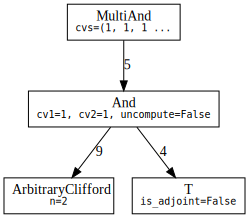

#### Counts totals:
 - `ArbitraryClifford(n=2)`: 45
 - `TGate()`: 20

In [1]:
from qualtran.drawing import show_call_graph, show_counts_sigma
from qualtran.bloqs.and_bloq import MultiAnd, And

graph, sigma = MultiAnd(cvs=(1,)*6).call_graph()

show_call_graph(graph)
show_counts_sigma(sigma)

## Interface

The primary method for accessing the call graph of a bloq is `Bloq.call_graph()`. It returns a networkx graph as well as a dictionary of totals for "leaf" bloqs. 

Another method is `Bloq.bloq_counts`, which will return a dictionary of immediate children.

In [2]:
And().bloq_counts()

{ArbitraryClifford(n=2): 9, TGate(is_adjoint=False): 4}

These methods both take a `generalizer` argument.

Often, bloqs have attributes that are important for describing their specific action but don't affect the bloq's resource cost. For example, `Rx(0.12)` and `Rx(0.13)` should probably be considered equal when counting the number of operations. Another example is given below where we group all two-bit `And` operations no matter their control values. 

The `generalizer` argument is an optional callable that takes specific bloqs to general bloqs. In the next cell, we build a call graph with non-homogenous control values for `MultiAnd` which results in two different nodes for two-bit `And` showing up in the call-graph.

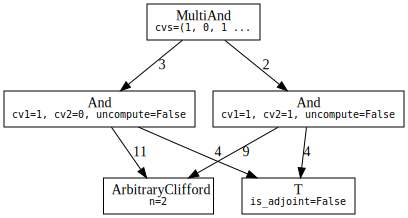

#### Counts totals:
 - `ArbitraryClifford(n=2)`: 51
 - `TGate()`: 20

In [3]:
graph, sigma = MultiAnd(cvs=(1,0)*3).call_graph()
show_call_graph(graph)
show_counts_sigma(sigma)

This level of detail might not be relevant for your particular research. Below, we define a `generalize` function that replaces all control values with placeholder symbol values.

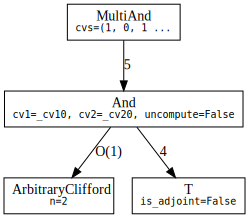

#### Counts totals:
 - `ArbitraryClifford(n=2)`: $\displaystyle O\left(1\right)$
 - `TGate()`: 20

In [4]:
from qualtran.resource_counting import SympySymbolAllocator
import attrs

ssa = SympySymbolAllocator()
cv1 = ssa.new_symbol('cv1')
cv2 = ssa.new_symbol('cv2')

def ignore_cv(bloq):
    if isinstance(bloq, And):
        return attrs.evolve(bloq, cv1=cv1, cv2=cv2)
    
    return bloq

graph, sigma = MultiAnd(cvs=(1,0)*3).call_graph(generalizer=ignore_cv)
show_call_graph(graph)
show_counts_sigma(sigma)

We no longer have a specific clifford count (it has been replaced with `O(1)`), but we have a much simpler graph topology.

## Additional functionality

The `qualtran.resource_counting` module provides the functionality for building and manipulating call graphs.

## Implementation

The call graph functionality relies on the `Bloq.build_call_graph(...)` method to implement the protocol. This is where a given bloq's callees is actually encoded.

Bloq authors may want to override this method. The system will provide a `SympySymbolAllocator` when calling this method to assist with symbolic resource estimates. Below, we sketch out a bloq with custom bloq counts.

In [5]:
from functools import cached_property
from typing import Dict, Optional, Set, Union

from attrs import frozen

from qualtran import Bloq, BloqBuilder, Register, Side, Signature, SoquetT
from qualtran.resource_counting import BloqCountT, SympySymbolAllocator

import sympy

from qualtran.bloqs.basic_gates import CNOT

@frozen
class MyFunc(Bloq):
    n: Union[int, sympy.Expr]

    @cached_property
    def signature(self) -> 'Signature':
        return Signature.build(x=self.n)

    def build_call_graph(self, ssa: 'SympySymbolAllocator') -> Set['BloqCountT']:
        return {
            (And(), 2*self.n),
            (CNOT(), 5),
        }

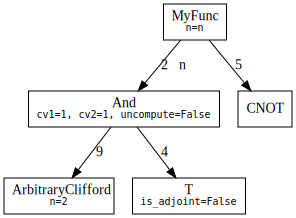

#### Counts totals:
 - `ArbitraryClifford(n=2)`: $\displaystyle 18 n$
 - `CNOT()`: 5
 - `TGate()`: $\displaystyle 8 n$

In [6]:
myfunc = MyFunc(n=sympy.sympify('n'))
graph, sigma = myfunc.call_graph()
show_call_graph(graph)
show_counts_sigma(sigma)

## Default Fallback

If a bloq does not override `build_call_graph(...)`, the default fallback will be used by Qualtran to support the call graph protocol.

By default, Qualtran will use the decomposition to count subbloqs called by the bloq. For example, below we author a `SWAP` bloq. We define a decomposition but do not explicitly provide the call graph counts.

In [7]:
@frozen
class MySwap(Bloq):

    @cached_property
    def signature(self) -> 'Signature':
        return Signature.build(q0=1, q1=1)
    
    def build_composite_bloq(self, bb, q0, q1):
        q0, q1 = bb.add(CNOT(), ctrl=q0, target=q1)
        q1, q0 = bb.add(CNOT(), ctrl=q1, target=q0)
        q0, q1 = bb.add(CNOT(), ctrl=q0, target=q1)
        return {'q0': q0, 'q1': q1}

The system will simply decompose the bloq and count up the children.

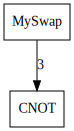

#### Counts totals:
 - `CNOT()`: 3

In [8]:
graph, sigma = MySwap().call_graph()
show_call_graph(graph)
show_counts_sigma(sigma)